In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [3]:
input_location = 'KTH-io-aware'
files_prefix = ''
schedule_names = ['balance-08-smallest-1', 'balance-09-smallest-1', 'balance-10-smallest-1', 'balance-11-smallest-1', 'balance-12-smallest-1', 'balance-13-smallest-1', 'balance-14-smallest-1']

In [4]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/backfill-sjf-1_schedule.csv', '../output/KTH-io-aware/balance-08-largest-1_schedule.csv', '../output/KTH-io-aware/balance-08-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-08-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-09-largest-1_schedule.csv', '../output/KTH-io-aware/balance-09-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-09-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-10-largest-1_schedule.csv', '../output/KTH-io-aware/balance-10-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-10-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-11-largest-1_schedule.csv', '../output/KTH-io-aware/balance-11-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-11-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-12-largest-1_schedule.csv', '../output/KTH-io-aware/balance-12-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-12-smallest-1_schedule.csv', 

In [5]:
def schedule_params(schedule_name):
    _, balance_factor, priority_policy, _ = schedule_name.split('-')
    balance_factor = float(balance_factor) / 10
    return priority_policy, balance_factor

In [6]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        priority_policy, balance_factor = schedule_params(schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df['priority_policy'] = priority_policy
        df['balance_factor'] = balance_factor
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 balance-08-smallest-1
 balance-09-smallest-1
 balance-10-smallest-1
 balance-11-smallest-1
 balance-12-smallest-1
 balance-13-smallest-1
 balance-14-smallest-1


In [7]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        priority_policy, balance_factor = schedule_params(schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)
        jobsets[schedule_name].df['priority_policy'] = priority_policy
        jobsets[schedule_name].df['balance_factor'] = balance_factor

 balance-08-smallest-1
 balance-09-smallest-1
 balance-10-smallest-1
 balance-11-smallest-1
 balance-12-smallest-1
 balance-13-smallest-1
 balance-14-smallest-1


In [8]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [9]:
for schedule in schedule_names:
    print(schedule)
    jobsets[schedule].df = transform_jobset(schedule)

balance-08-smallest-1
balance-09-smallest-1
balance-10-smallest-1
balance-11-smallest-1
balance-12-smallest-1
balance-13-smallest-1
balance-14-smallest-1


In [10]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

def create_balance_metric_df():
    dfs = []
    for schedule in schedule_names:
        priority_policy, balance_factor = schedule_params(schedule)
        dfs.append(jobsets[schedule].df[['waiting_time', 'turnaround_time', 'stretch']].assign(priority_policy=priority_policy).assign(balance_factor=balance_factor))
    return pd.concat(dfs)

In [11]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [12]:
metrics.T

schedule,balance-08-smallest-1,balance-09-smallest-1,balance-10-smallest-1,balance-11-smallest-1,balance-12-smallest-1,balance-13-smallest-1,balance-14-smallest-1
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0
makespan,2.88131e+07,2.88188e+07,2.87941e+07,2.88106e+07,2.8805e+07,2.88045e+07,2.88027e+07
max_slowdown,1.00023,1.00022,1.00023,1.00023,1.00022,1.00023,1.00023
max_turnaround_time,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975916,0.975918,0.975918,0.975919,0.975918,0.975918,0.975924
mean_turnaround_time,223.716,223.745,223.694,223.695,223.71,223.734,223.654
mean_waiting_time,0,0,0,0,0,0,0
nb_computing_machines,109,109,109,109,109,109,109


<AxesSubplot:xlabel='balance_factor'>

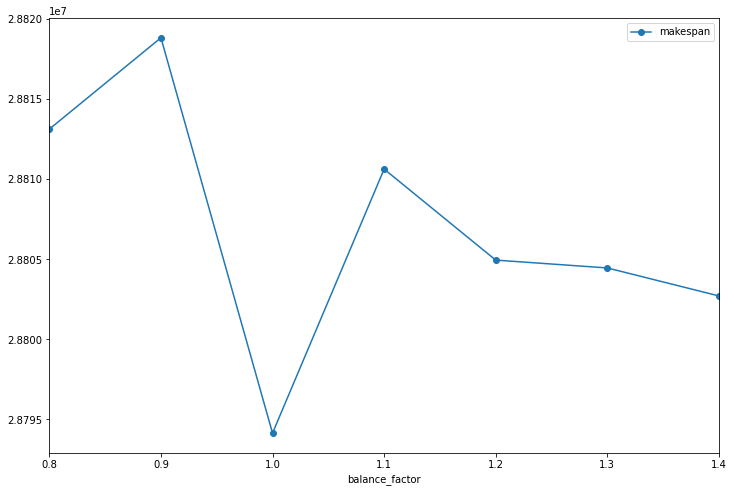

In [13]:
metrics.plot(x='balance_factor', y='makespan', marker='o', figsize=(12, 8))

<AxesSubplot:xlabel='balance_factor'>

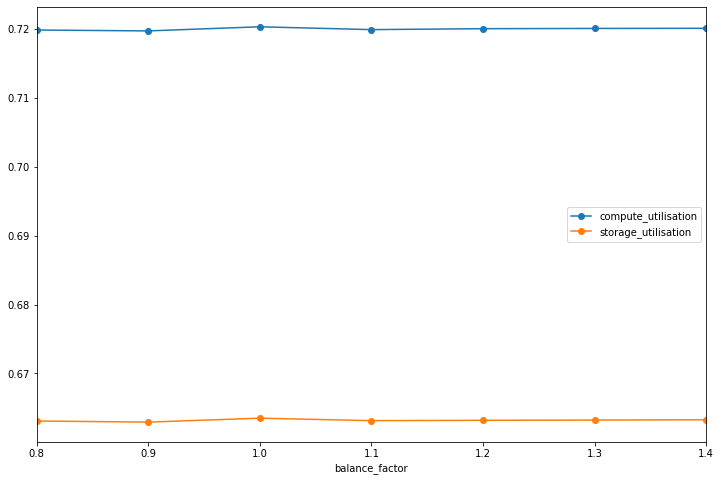

In [14]:
metrics.plot(x='balance_factor', y=['compute_utilisation', 'storage_utilisation'], marker='o', figsize=(12, 8))

<AxesSubplot:xlabel='balance_factor'>

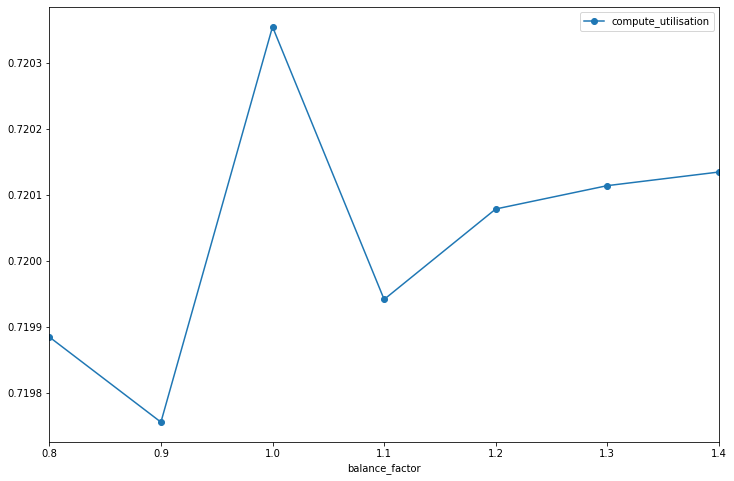

In [15]:
metrics.plot(x='balance_factor', y='compute_utilisation', marker='o', figsize=(12, 8))

<AxesSubplot:xlabel='balance_factor'>

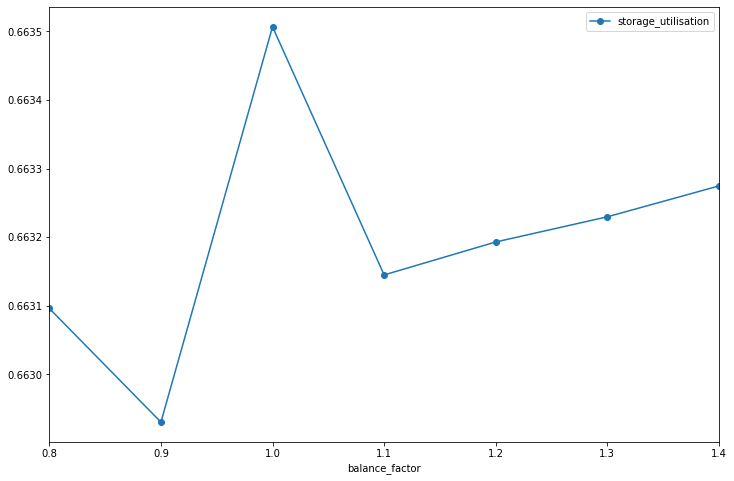

In [16]:
metrics.plot(x='balance_factor', y='storage_utilisation', marker='o', figsize=(12, 8))

<AxesSubplot:xlabel='balance_factor', ylabel='compute_utilisation'>

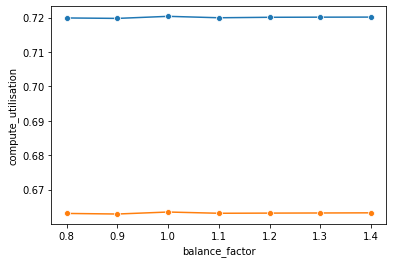

In [17]:
sns.lineplot(data=metrics[['balance_factor', 'compute_utilisation']], x='balance_factor', y='compute_utilisation', marker='o')
sns.lineplot(data=metrics[['balance_factor', 'storage_utilisation']], x='balance_factor', y='storage_utilisation', marker='o')

In [18]:
metrics[['balance_factor', 'compute_utilisation', 'storage_utilisation']]

,balance_factor,compute_utilisation,storage_utilisation
schedule,,,
balance-08-smallest-1,0.8,0.719885,0.663096
balance-09-smallest-1,0.9,0.719756,0.662930
balance-10-smallest-1,1.0,0.720355,0.663507
balance-11-smallest-1,1.1,0.719942,0.663145
balance-12-smallest-1,1.2,0.720079,0.663193
balance-13-smallest-1,1.3,0.720115,0.663230
balance-14-smallest-1,1.4,0.720135,0.663275


In [19]:
df = create_balance_metric_df()

In [20]:
df[['balance_factor', 'waiting_time', 'stretch']].groupby('balance_factor').describe()

waiting_time                                             \
                      count          mean           std  min  25%  50%   
balance_factor                                                           
0.8                 28453.0  15415.309941  46900.506112  0.0  0.0  0.0   
0.9                 28453.0  14619.072026  44828.090581  0.0  0.0  0.0   
1.0                 28453.0  15128.112074  45478.503683  0.0  0.0  0.0   
1.1                 28453.0  15443.725766  46908.240144  0.0  0.0  0.0   
1.2                 28453.0  14217.327237  44303.431750  0.0  0.0  0.0   
1.3                 28453.0  14988.040913  45860.402810  0.0  0.0  0.0   
1.4                 28453.0  14400.659378  44301.490100  0.0  0.0  0.0   

                                            stretch                           \
                        75%            max    count        mean          std   
balance_factor                                                                 
0.8             7198.445730  606435.210451  28453.0  136.428215   772.309232   
0.9             7877.368611  729815.695473  28453.0  156.409142  1018.417150   
1.0             7196.189259  595144.951135  28453.0  137.064564   831.840310   
1.1             7372.326401  608018.122431  28453.0  139.045292   844.134539   
1.2             6176.301827  631015.303533  28453.0  139.625944   857.211919   
1.3             7179.326930  625234.311488  28453.0  130.473001   705.746160   
1.4             6984.013940  595238.915092  28453.0  141.440390   911.252540   

                                                       
                min  25%  50%       75%           max  
balance_factor                                         
0.8             1.0  1.0  1.0  5.166132  33160.248018  
0.9             1.0  1.0  1.0  5.535964  66142.765663  
1.0             1.0  1.0  1.0  5.060580  58948.926005  
1.1             1.0  1.0  1.0  5.505277  83239.520119  
1.2             1.0  1.0  1.0  4.742767  38076.791776  
1.3             1.0  1.0  1.0  5.228796  23564.430031  
1.4             1.0  1.0  1.0  4.848125  46684.758140

<AxesSubplot:xlabel='balance_factor', ylabel='waiting_time'>

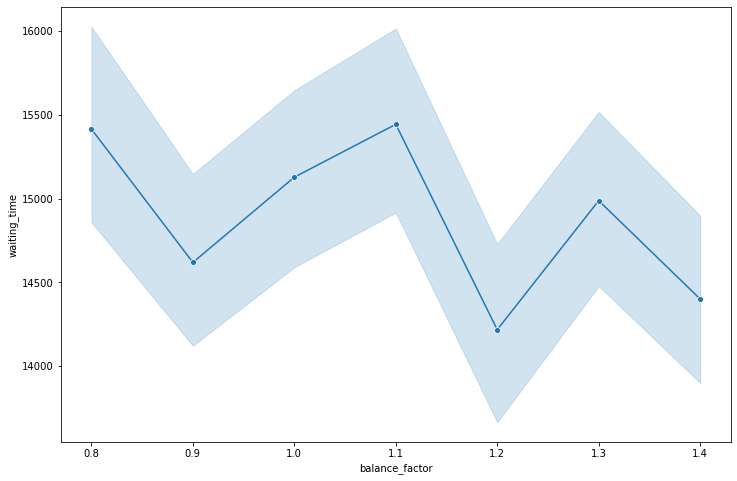

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df, x='balance_factor', y='waiting_time', estimator=np.mean, marker='o', ax=ax)

<AxesSubplot:xlabel='balance_factor', ylabel='stretch'>

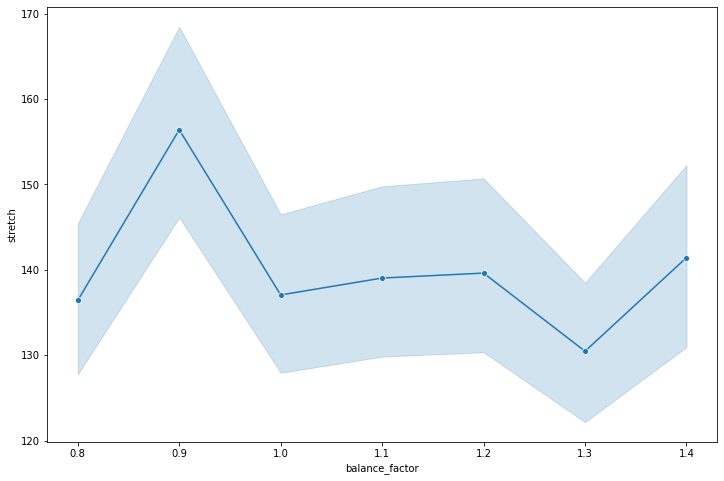

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df, x='balance_factor', y='stretch', estimator=np.mean, marker='o', ax=ax)